In [1]:
import pandas as pd
import json
import requests
import numpy as np
import joblib
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import ast


In [2]:
date = '08.13.25'

# Load list of mithochondria-targetted compounds
# See for reference Wagner, B., Kitami, T., Gilbert, T. et al. 
# Large-scale chemical dissection of mitochondrial function.
# Nat Biotechnol 26, 343–351 (2008). https://doi.org/10.1038/nbt1387
mito_perturbations = pd.read_csv('mito_perturbations.csv', header=2)

# Load cell annotations
annot = pd.read_csv('cell-annotation.csv')
# Store cell type categories
cells_cat = list(annot['cell.type'].unique())

def overlap(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

# Initialize a set to store all unique genes
unique_genes = set()

# Load genes from each cell type and add to the set
for cell_type in tqdm(cells_cat, desc="Loading genes by cell type"):  
    genes_list = np.load(f'./ROSMAP_seurat_QC/by_cell_type/{cell_type}_genes_names.npy', allow_pickle=True)
    unique_genes.update(genes_list)

# Separate mitochondrial and nuclear genes
MT_genes = sorted([gene for gene in unique_genes if gene.startswith('MT-')])
nuc_genes = sorted(unique_genes - set(MT_genes))

# Compute overlapping genes across all cell types
overlap_genes = unique_genes.copy()
for cell_type in tqdm(cells_cat, desc="Computing overlap"):
    genes_list = set(np.load(f'./ROSMAP_seurat_QC/by_cell_type/{cell_type}_genes_names.npy', allow_pickle=True))
    overlap_genes = overlap(overlap_genes, genes_list)

overlap_genes = sorted(overlap_genes)

MT_genes = [gene for gene in overlap_genes if gene.startswith('MT-')]
nuc_genes = [gene for gene in overlap_genes if not gene.startswith('MT-')]

print("Mitochondrial genes:")
for gene in MT_genes:
    print(gene)

Computing overlap: 100%|██████████| 16/16 [00:00<00:00, 571.15it/s]

Mitochondrial genes:
MT-ATP6
MT-ATP8
MT-CO1
MT-CO2
MT-CO3
MT-CYB
MT-ND1
MT-ND2
MT-ND3
MT-ND4
MT-ND4L
MT-ND5
MT-ND6


In [ ]:
def L1000(pos_loadings,neg_loadings):

    url = 'https://maayanlab.cloud/L1000CDS2/query'

    data = {}
    # separate positive and negative loadings 
    data['upGenes'] = pos_loadings
    data['dnGenes'] = neg_loadings

    # because PLS-C is symmetric, try both up and down regulation
    config = {"aggravate":True,"searchMethod":"geneSet","share":True,"combination":True,"db-version":"latest"}
    metadata = [{"key":"Tag","value":"gene-set python example"},{"key":"Cell","value":"MCF7"}]
    payload = {"data":data,"config":config,"meta":metadata}
    headers = {'content-type':'application/json'}
    r = requests.post(url,data=json.dumps(payload),headers=headers)
    resGeneSet = r.json()
    resGeneSet_df = pd.DataFrame.from_dict(resGeneSet['topMeta'])

    return resGeneSet_df

In [ ]:
date = '08.13.25'
for cell_type in [
    'Excitatory Neurons',
    'Oligodendrocytes',
    'Inhibitory Neurons',
    'Astrocyte',
    'Microglia',
    'OPCs'
    ]:
    pls = joblib.load(f'{date}/MT_PLS/pls_{cell_type}.gz')
    url = 'https://maayanlab.cloud/L1000CDS2/query'

    for comp in range(0,13):
        # print(f'{cell_type}: component {comp+1}')
        genes = nuc_genes
        loadings = pd.Series(pls.x_loadings_[:,comp], index=genes)
        pos_loadings = list(loadings.loc[loadings<0].index)
        neg_loadings = list(loadings.loc[loadings>0].index)

        # since PLS-C is symmetrical, try both up- and down-regulation
        resGeneSet_df = L1000(pos_loadings,neg_loadings)
        resGeneSet_df.to_csv(f'{date}/MT_PLS/perturbations/{cell_type}_component_{comp+1}_v1.csv')
        resGeneSet_df = L1000(neg_loadings,pos_loadings)
        resGeneSet_df.to_csv(f'{date}/MT_PLS/perturbations/{cell_type}_component_{comp+1}_v2.csv')

    print('\n')

In [5]:
top_pert = pd.DataFrame()
for cell_type in [
    'Excitatory Neurons',
    'Oligodendrocytes',
    'Inhibitory Neurons',
    'Astrocyte',
    'Microglia',
    'OPCs'
    ]:
    for comp in range(0,13):
        # Load data
        pos = pd.read_csv(f'{date}/MT_PLS/perturbations/{cell_type}_component_{comp+1}_v1.csv', index_col=0)
        neg = pd.read_csv(f'{date}/MT_PLS/perturbations/{cell_type}_component_{comp+1}_v2.csv', index_col=0)
        
        df = pd.concat([pos, neg], axis=0)
        
        # Filter by overlap list
        df['cell_comp'] = f'{cell_type}_comp{comp+1}'

        df.to_csv(f'{date}/MT_PLS/perturbations/{cell_type}_comp_{comp+1}_all_pert.csv')
        
        # Keep max score per pert_desc for this cell_type/component
        idx = df.groupby('pert_desc')['score'].idxmax()
        df_max = df.loc[idx, ['pert_desc', 'score', 'cell_comp']]

        top_n = df_max.sort_values('score', ascending=False).drop_duplicates().head(3)

        top_pert = pd.concat([top_pert, top_n])


In [6]:
top_pert_unique = list(np.unique(top_pert.pert_desc))
top_pert_unique.remove('-666')
len(top_pert_unique)

71

In [7]:
top_mito = []
for chemical in top_pert_unique:
    if str(chemical).lower() in [name.lower() for name in mito_perturbations.CompoundName]:
        print(chemical)
        top_mito.append(chemical)

Camptothecin
DACTINOMYCIN
NICLOSAMIDE
Parthenolide
TENIPOSIDE


In [8]:
top_mito = ['Camptothecin', 'DACTINOMYCIN', 'NICLOSAMIDE', 'Parthenolide', 'TENIPOSIDE']

In [9]:
date = '08.13.25'

for chemical in top_mito:
    
    chem_gen_set = set()

    for cell_type in tqdm([
        'Excitatory Neurons',
        'Oligodendrocytes',
        'Inhibitory Neurons',
        'Astrocyte',
        'Microglia',
        'OPCs'
        ]):
        cell = []
        for comp in range(0,13):

            # since PLS-C is symmetrical, try both up- and down-regulation
            df =  pd.read_csv(f'{date}/MT_PLS/perturbations/{cell_type}_comp_{comp+1}_all_pert.csv', index_col=0)

            # Keep max score per pert_desc for this cell_type/component
            idx = df.groupby('pert_desc')['score'].idxmax()
            df_max = df.loc[idx, ['pert_desc', 'score', 'cell_comp', 'overlap']]

            if df_max.loc[df_max.pert_desc==chemical].empty:
                 continue
            else:
                for geneset in df_max['overlap'].dropna():
                    # print(geneset)
                    geneset = ast.literal_eval(geneset)
                    for key, value in geneset.items():
                        for gene in geneset[key]:
                            chem_gen_set.add(gene)

    print(f'{chemical} gene set: {len(list(chem_gen_set))}')
    np.save(f'{date}/MT_PLS/perturbations/{chemical}_gene_list.npy', np.array(list(chem_gen_set)))

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00,  9.07it/s]


Camptothecin gene set: 1603


100%|██████████| 6/6 [00:00<00:00, 13.60it/s]


DACTINOMYCIN gene set: 1519


100%|██████████| 6/6 [00:00<00:00, 17.02it/s]


NICLOSAMIDE gene set: 1549


100%|██████████| 6/6 [00:00<00:00, 14.23it/s]


Parthenolide gene set: 1595


100%|██████████| 6/6 [00:00<00:00, 16.39it/s]

TENIPOSIDE gene set: 1558


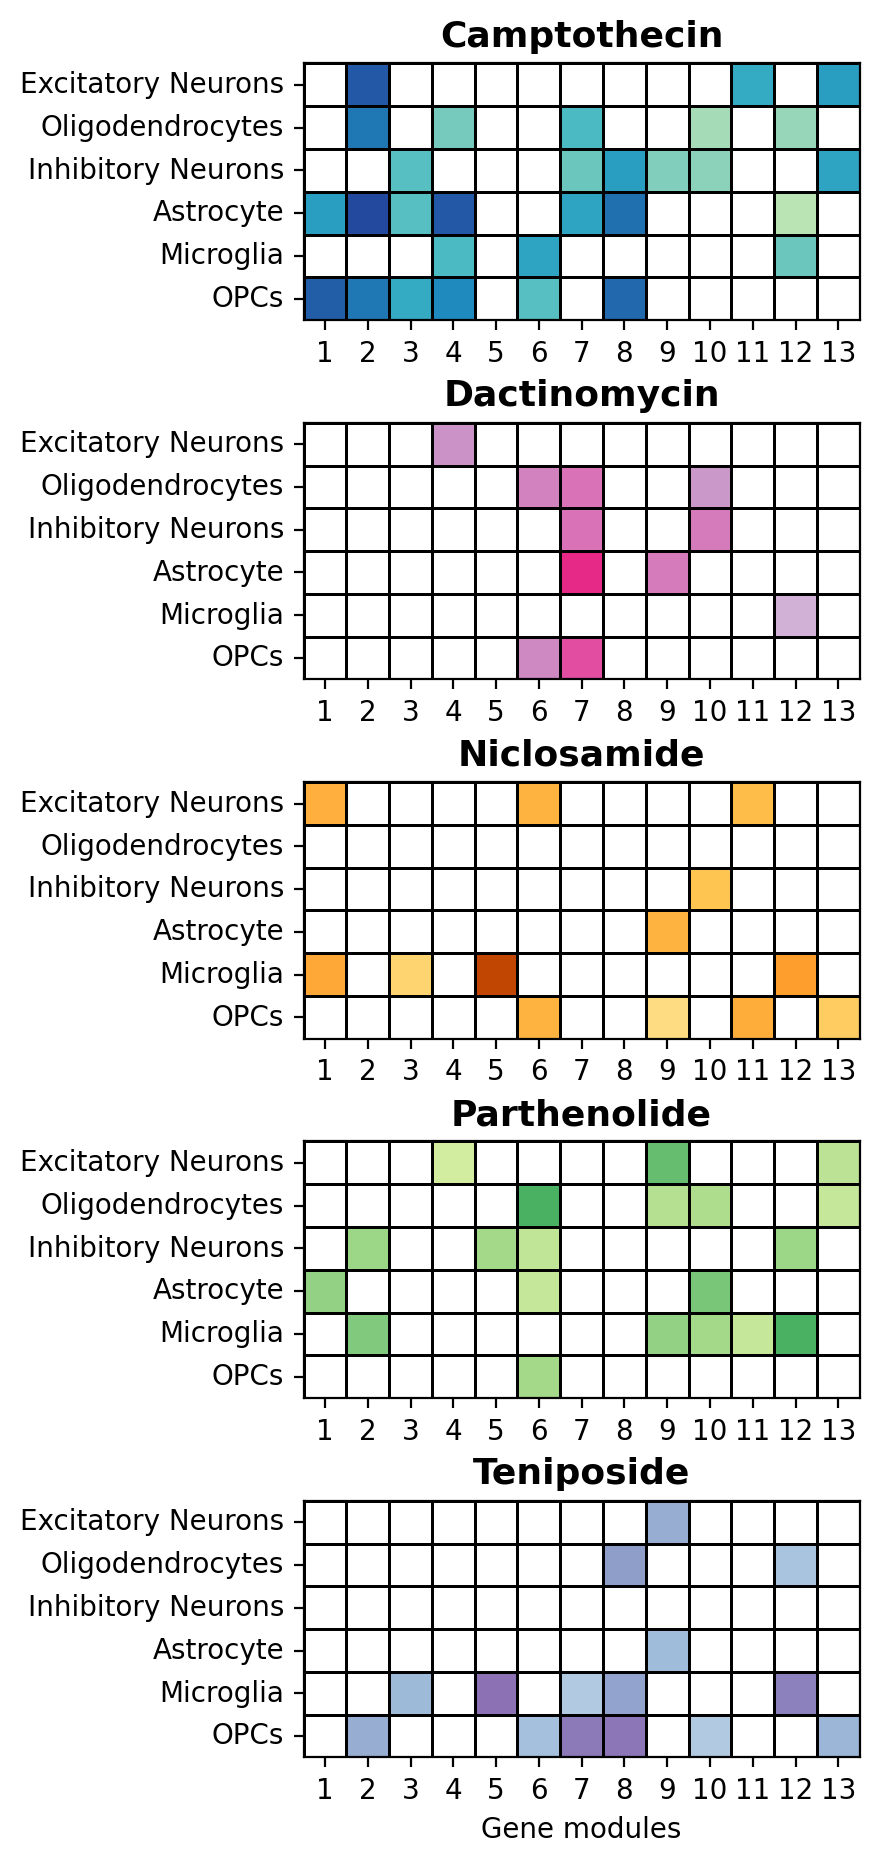

In [10]:
color = ['YlGnBu', 'PuRd', 'YlOrBr', 'YlGn', 'BuPu']

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 11), dpi=200)

# keep references to heatmaps
hms = []

for k, chemical in enumerate(top_mito):
    to_plot = pd.read_csv(f'{date}/MT_PLS/perturbations/{chemical}.csv', index_col=0)

    ax = axes[k]
    hm = sns.heatmap(
        to_plot.astype('float'),
        cmap=color[k],
        vmin=0,
        vmax=0.04,
        square=True,
        cbar=False,   # <---- turn off colorbar here
        xticklabels=range(1, 14),
        linewidth=0.5,
        linecolor="black",
        ax=ax
    )
    ax.set_title(chemical.capitalize(), fontweight='bold', fontsize=13)
    ax.set_ylabel("")
    ax.spines[:].set_visible(True)
    hms.append(hm)
axes[4].set_xlabel("Gene modules")

# now create a row of colorbars at the top
# cbar_fig, cbar_axes = plt.subplots(1, 5, figsize=(15, 1.5))  # one row of 5 colorbars
fig.subplots_adjust(hspace=0.4) 

# plt.tight_layout()
#fig.savefig(f"{date}/updated_plots/MT_PLS/LINCS_all_oneRowCB.png", dpi=200, bbox_inches="tight")
plt.show()
plt.close('all')


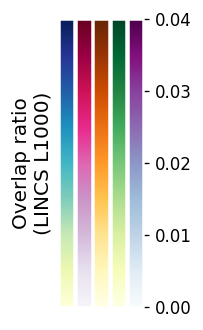

In [ ]:
# second figure: only colorbars
cbar_fig = plt.figure(figsize=(0.8, 4), dpi=120)

# create 5 small vertical axes manually (fixed width, aligned horizontally)
cbar_axes = [
    cbar_fig.add_axes([0.05 + i*0.18, 0.2, 0.16, 0.6])  # [left, bottom, width, height]
    for i in range(5)
]

for k, hm in enumerate(hms):
    cbar = cbar_fig.colorbar(
        hm.collections[0],
        cax=cbar_axes[k],
        orientation="vertical"
    )
    
    # only show ticks on the last bar
    if k != 4:  
        cbar.set_ticks([])  # hide ticks
    else:
        ticks = np.linspace(0, 0.04, 5)
        cbar.set_ticks(ticks)
        cbar.ax.tick_params(labelsize=10)
        cbar.set_label("Overlap ratio\n(LINCS L1000)", fontsize=12, labelpad=45)
        cbar.ax.yaxis.set_label_position("left")

    # style outline
    cbar.outline.set_edgecolor("white")
    cbar.outline.set_linewidth(1.5)

plt.show()
